# Introdução à Computação Visual
## TP1 - Compressor de imagens
### João Marcos Machado Couto

### Introdução

Sob o desafio de implementar um stack de compressão de imagens, este TP provou-se altamente instigante sobretudo devido à grande quantidade de combinações possiveis entre as várias categorias de redundancia e suas respectivas técnicas de compressão

Inicialmente pensei em utilizar uma redução da profundidade da mensagem seguida de Huffman e uma codificação por corridas. Porém neste ponto percebi que utilizar Huffman e posteriormente codificar a mensagem com base em corridas não é tão muito efetivo pois embora os pixels de maior frequencia (e portanto, menor representação) de fato vão aparece mais vezes em corridas, parte desse ganho será perdido pela necessidade de armezenar o tamanho das corridas

Foi ai que percebi que o algoritmo de Huffman "não liga" se os simbolos que estão sendo imputados são pixels de uma imagem ou não.. Ele encontra uma representação mais proxima da entropia indiferentemente do que os simbolos representam.. então a principio juntar simbolos de dominios diferentes não seria um problema, certamente pelo menos não ficara pior do que armazenar os dois dominios de simbolos separadamente

Decidi então apostar nesse ideia central: utilizar Huffman DEPOIS de codificar a mensagem em corridas, juntanto simbolos referentes a tons de cinza com simbolos referentes ao tamanho das corridas na esperança de que a interseção entre eles seja grande o suficiente para gerar simbolos de alta probabilidade para ambos, antes disso reduzindo a profundidade da imagem em 4 bits para significantemente aumentar o tamanho médio das corridas

<strong> Ao final das contas, gastei pelo menos 5 vezes mais tempo de implementação lidando com várias tentativas de salvar todas os dados comprimidos em apenas um unico e elegante arquivo stream de binarios (isto é, não somente a imagem mas também o dicionario da tabela de Huffman em forma binária</strong>

<strong> Nessa tentativa, acabei gastando um tempo muito desporporcional com idiosincrasias da manipulação de arquivos binários crus em python, algo não essencial para o objetivo principal do trabalho. Assim, em retrospecto, vejo que deveria ter simplesmente salvo a tabela Huffman utilizando um pickle mais cedo e entregue o trabalho a tempo, que já estava plenamente funcional exceto por não utilizar apenas um arquivo em disco </strong>

### Imports e leitura da imagem

In [1]:
%matplotlib inline
import cv2
import numpy as np
import pylab
from matplotlib import pyplot as plt

%matplotlib inline
pylab.rcParams['figure.figsize'] = (20.0, 7.0)


In [2]:
imPath = 'barb.tif'
#imPath = 'lena512.pgm'


In [3]:
img = cv2.imread(imPath,0)
#im = im.astype(float)


### Redundancia psicovisual: redução da profundidade dos pixels

In [4]:
im = img & 0xf0


In [5]:
imShape = im.shape

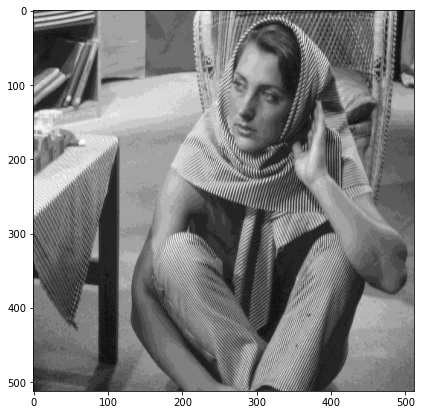

In [6]:
f = plt.figure()
plt.imshow(im,cmap='gray')

### Codificando a imagem com base em corridas: tuplas (tom de cinza, extensão da corrida)

In [7]:
encodedUncompressed = [] 

anterior = im[0][0] #Inacializa o pixel anterior com o primeiro da imagem

corridas = []

corrente = 0 #Contador da corrida corrente de cada interaçào
numCorridas = 0
for linha in im:
    for pixel in linha:
        if pixel == anterior: 
            corrente = corrente + 1
        else:
            numCorridas = numCorridas + 1
            encodedUncompressed.append(anterior) #Ao fim de uma corrida apendamos o tom de cinza associado a ela
            encodedUncompressed.append(corrente) #E tambem a extensão da corrida
            corridas.append(corrente)
            corrente = 0 
            anterior = pixel

encodedUncompressed.append(anterior)
encodedUncompressed.append(corrente)

corridas.append(corrente)

corridas[0] = corridas[0]-1 #Correção necessaria pois o primeiro pixel acaba se contando duas vezes como consequencia da inicialização 
encodedUncompressed[1] = encodedUncompressed[1] -1 

encodedUncompressed = np.array(encodedUncompressed)
        
        

In [8]:
import collections

In [9]:
counter = collections.Counter(encodedUncompressed)

In [10]:
symb2count = dict(counter) #Dicionario associando symbolos com seu número de ocorenccias

In [11]:
total = sum(counter.values()) #Somatorio de todas ocorrencias as extensões de corrida e tom de cinza

In [12]:
symb2freq = {k: v/total for k, v in symb2count.items()} #

### Aplicação de Huffman diretamente sobre a codificação em corridas da imagem

In [13]:

from heapq import heappush, heappop, heapify
from collections import defaultdict
def encode(symb2freq):#Recebe simbolos associados com suas respectivas frequencias na imagem
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p)) #Solta simbolos associados com sua nova codificação"

In [14]:
huff = encode(symb2freq)
huff = dict([tuple(a) for a in huff])

## Compressão da imagem utilizando a tabela de Huffman sintetizada na forma de um dicionario

In [15]:
encodedCompressed = '' #Armazena a imagem após processamento pela tabela de huffman
for item in encodedUncompressed:
    encodedCompressed = encodedCompressed + huff[item]

In [16]:
contador =0
f = open('compressedFile.bin', 'wb')

bitsNoUltimo = 0 #Necessario pois ao escrever o último segmento da imagem, é possivel que o os bits da imagem comprimida não utilize todos os bits do último byte..
#.. Por consequencia é, faz-se necessario salvar um byte adicional informando o decodificador quantos bits do ultima byte são significativos..
#.. Para que ele possa então fazer este tratamento

for contador in range(0,len(encodedCompressed),8): #Faze-se a escrita de 8 em 8 bits da imagem comprimida
    if( (contador+8) > (len(encodedCompressed))):
        bitsNoUltimo = contador+8 - len(encodedCompressed)
        
        f.write(bytes([int(encodedCompressed[contador:],base=2)])) 
    else :
        f.write(bytes([int(encodedCompressed[contador:contador+8],base=2)])) 
    
 
    
f.write(bytes([bitsNoUltimo])) #Corner-case ultimos bits
f.close()

In [17]:
import pickle
f = open("CompressionOverhead.pkl","wb")
dump = (huff, imShape)
pickle.dump(dump,f)
f.close()

# Transição Encode->Decode #

Apartir deste ponto os comandos são inteiramente independentes do código acima. Basta carregar o binario da imagem comprimida e o pickle com sua tabela de Huffman

In [18]:
with open("CompressionOverhead.pkl", "rb") as f:
    (huffFromFile, imShapeFromFile) = pickle.load(f)

In [19]:
f = open('compressedFile.bin', 'rb')
byte = f.read(1)
compresedFromFile = ''
temp = ''
while byte:

    temp = bin(int.from_bytes(byte,byteorder='big')) #Traduz a formatação de python byte para uma sequencia de 0's e 1's
    a = temp[2:] # Descarta a formatação retornada por bin : 0b111 vira 111
    compresedFromFile  = compresedFromFile + str(a).zfill(8) #Recompõe os bytes com os zeros não significativos 

    byte = f.read(1)
f.close()

#Inicio do tratamento do corner-case do último byte: reposiciona os bits menos significativos para a posição original
#Remove tambem o byte adicional utilizado para comunicação a cerca do tamanho do byte final
#Assim, 00010100|00000110 nos dois ultimos bytes de compressedFromFile se tornam 010100 apenas, como na imagem comprimida original
bitsNoUltimoFromFile = int(compresedFromFile[-8:], base=2) #Faz a leitura de quantos bytes significativos o ultimo byte realmente tinha
temp = list(compresedFromFile[0:-8]) #Remove o "meta-byte" utiliado apenas para comunicar a informação obtida na linha acima
compresedFromFile = ''
compresedFromFile = compresedFromFile.join(temp) 
filler = compresedFromFile[-(8-bitsNoUltimoFromFile):] #Identifica e separa os bits significativos
temp = list(compresedFromFile)
temp[-8:-bitsNoUltimoFromFile] = list(filler) #Desloca os bits significativos pro começo do byte
temp = temp[0:-bitsNoUltimoFromFile] #Remove os 0 adicionais


compresedFromFile =''
compresedFromFile =compresedFromFile.join(temp)




In [20]:
inverseHuff = {v: k for k, v in huffFromFile.items()} #Inverse o dicionario huffman recebido do arquivo

In [21]:
item = ''
encodedDecompressed = []
contador =0
for bit in compresedFromFile:
    item = item + str(bit)
    item = str(item)
    if item in inverseHuff.keys():
        encodedDecompressed += [inverseHuff[item]] #Traduz a codificação comprimida de volta para codificação de corrida regular
        item = ''
    

In [22]:
decodedImage = []
dupla =0
pixelValue= 0
corridaCount = 0
corrida = []

for item in encodedDecompressed:
    if (dupla ==0):
        pixelValue =item
        dupla = 1
    else:
        decodedImage.extend([pixelValue] * (item+1)) #Traduz a codificação de corrida de volta para a imagem original
        dupla = 0

In [23]:
reconstructedImage = np.array(decodedImage).reshape(imShapeFromFile) #Utiliza o shape lido do arquivo para colocar os bits no formato da imagem original

In [24]:
from math import log10, sqrt 

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [25]:
print("O PSNR da imagem reconstruida apartir do arquivo comprimido foi:")
PSNR(img,reconstructedImage)

O PSNR da imagem reconstruida apartir do arquivo comprimido foi:


29.323188270269664

In [26]:
import os
originalBytes= os.stat(imPath).st_size
compressedBytes = os.stat('compressedFile.bin').st_size + os.stat('CompressionOverhead.pkl').st_size
print("Taxa de compressão final:", originalBytes/compressedBytes)

Taxa de compressão final: 2.2649659746450657


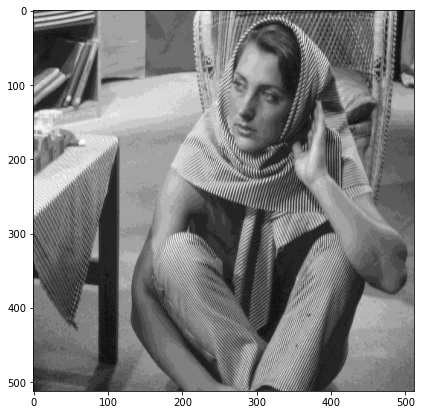

In [27]:
f = plt.figure()
plt.imshow(reconstructedImage,cmap='gray')